# Hotdog/Not-Hotdog Classifier Using Transfer Learning

In [2]:
import os

import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import pathlib as path
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

In [3]:
keras.backend.clear_session()

In [4]:
DATA = path.Path('./data')
batch_size = 32

In [5]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [10]:
train_generator = datagen.flow_from_directory(
        (DATA/'train').as_posix(),
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode=None,  
        shuffle=False)

Found 2347 images belonging to 2 classes.


## Creating Inception Net bottleneck features for train and test sets

In [11]:
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [13]:
bottleneck_features_train = model.predict_generator(train_generator, 15000/batch_size, verbose=1)

469/468 [==============================] - 109s 232ms/step


In [14]:
bottleneck_features_train.shape

(14882, 8, 8, 2048)

In [15]:
np.savez('inception_features_train', features=bottleneck_features_train)

In [16]:
test_generator = datagen.flow_from_directory(
        (DATA/'test').as_posix(),
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

Found 200 images belonging to 2 classes.


In [17]:
bottleneck_features_test = model.predict_generator(test_generator, 644/batch_size, verbose=1)
np.savez('inception_features_test', features=bottleneck_features_test)

21/20 [===============================] - 4s 207ms/step


In [18]:
train_data = np.load('inception_features_train.npz')['features']

In [19]:
train_data.shape

(14882, 8, 8, 2048)

In [20]:
train_labels = np.array([0] * 7441 + [1] * 7441)

In [21]:
train_labels.shape

(14882,)

In [25]:
test_data = np.load('inception_features_test.npz')['features']
test_labels = np.array([0] * 300 + [1] * 300)

In [26]:
test_data.shape

(600, 8, 8, 2048)

In [27]:
test_labels.shape

(600,)

In [28]:
classes = test_generator.class_indices
class_names = []
for key in classes.keys():
    class_names.append(key)
print(class_names)

['hotdog', 'nothotdog']


## Defining and training the Model

In [29]:
model = Sequential()

In [30]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=train_data.shape[1:], padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [34]:
checkpointer = ModelCheckpoint(filepath=(DATA/'weights_inception.hdf5').as_posix(), verbose=1, save_best_only=True)

In [35]:
# keras.utils.print_summary(model) doesn't work
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_188 (Conv2D)          (None, 8, 8, 32)          589856    
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 2, 2, 64)          18496     
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 1, 64)          0         
__________

In [36]:
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

history = model.fit(train_data, train_labels,
          epochs=50,
          batch_size=batch_size,
          validation_split=0.3,
          verbose=2,
          callbacks=[checkpointer], shuffle=True)


Train on 10417 samples, validate on 4465 samples
Epoch 1/50

Epoch 00001: val_loss improved from inf to 1.27293, saving model to data/weights_inception.hdf5
 - 8s - loss: 0.6012 - binary_accuracy: 0.7143 - val_loss: 1.2729 - val_binary_accuracy: 0.0000e+00
Epoch 2/50

Epoch 00002: val_loss improved from 1.27293 to 1.22288, saving model to data/weights_inception.hdf5
 - 4s - loss: 0.6004 - binary_accuracy: 0.7143 - val_loss: 1.2229 - val_binary_accuracy: 0.0000e+00
Epoch 3/50

Epoch 00003: val_loss did not improve from 1.22288
 - 4s - loss: 0.6009 - binary_accuracy: 0.7143 - val_loss: 1.2231 - val_binary_accuracy: 0.0000e+00
Epoch 4/50

Epoch 00004: val_loss improved from 1.22288 to 1.21697, saving model to data/weights_inception.hdf5
 - 4s - loss: 0.6007 - binary_accuracy: 0.7143 - val_loss: 1.2170 - val_binary_accuracy: 0.0000e+00
Epoch 5/50

Epoch 00005: val_loss did not improve from 1.21697
 - 4s - loss: 0.6001 - binary_accuracy: 0.7143 - val_loss: 1.2495 - val_binary_accuracy: 0.00

In [37]:
model.load_weights((DATA/'weights_inception.hdf5').as_posix())

In [38]:
rounded_predictions = model.predict_classes(test_data, batch_size=32, verbose=1)

600/600 [==============================] - 1s 2ms/step


## Creating Metrics

### Accuracy

In [39]:
model.evaluate(test_data,test_labels, verbose=1,batch_size=batch_size)

600/600 [==============================] - 0s 280us/step


[0.7763833395640055, 0.5]

### Confusion Matrix

<function matplotlib.pyplot.show(*args, **kw)>

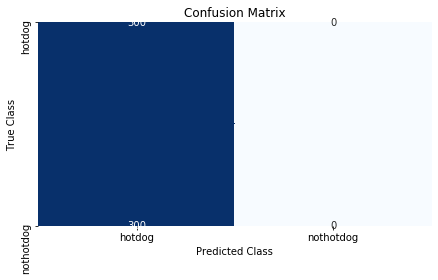

In [40]:
#Confusion Matrix
matrix = confusion_matrix(test_labels, rounded_predictions)

dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show

### Plotting training/validation accuracy and loss over the epochs

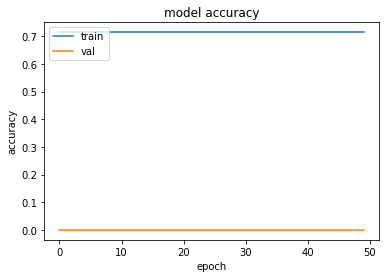

In [41]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'] )
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

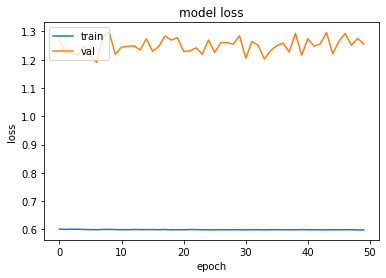

In [42]:
# summarize history for loss
plt.plot(history.history['loss'] )
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Finding out incorrectly classified images

In [43]:
incorrect_labels = []
incorrect_classification_indices = []
for i in range(rounded_predictions.shape[0]):
    if not rounded_predictions[i] == test_labels[i]:
        incorrect_classification_indices.append(i)
        incorrect_labels.append(rounded_predictions[i][0])

In [47]:
len(incorrect_classification_indices)

300

In [48]:
incorrect_classification_file_paths = []
for i in range(len(incorrect_classification_indices)):
    if incorrect_classification_indices[i] < 300:
        incorrect_classification_file_paths.append('hotdog/'+ os.listdir(DATA/'test/hotdog')[i])
    else:
        incorrect_classification_file_paths.append('nothotdog/'+ os.listdir(DATA/'test/nothotdog')[i])

IndexError: list index out of range

In [ ]:
print(cv2.__version__)
img_path = DATA/'test/'
def get_image(file_path):
    if os.path.isfile(img_path + file_path):
        image_bgr = cv2.imread(img_path + file_path,cv2.IMREAD_COLOR)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        image_rgb_resized = cv2.resize(image_rgb, (299, 299), interpolation = cv2.INTER_CUBIC)
        plt.imshow(image_rgb_resized)
        plt.axis("off")
        plt.show()

### Plotting a few incorrectly classified images

In [ ]:
for i in range(0, len(incorrect_classification_file_paths), 10):
    if 'nothotdog' in incorrect_classification_file_paths[i]:
        print("True:not hotdog")
    else:
        print("True:hotdog")
        
    if incorrect_labels[i] == 1:
        print("Pred:Not Hotdog")
    else:
        print("Pred:Hotdog")
    get_image(incorrect_classification_file_paths[i])